In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr

/mnt/ShareDrive/Development/UzK/COINs-CNN-FLOW/Uvenv/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Data Preparation

## Data Imports

### Flow Data

In [2]:
flow_predictions = pd.read_csv('../results/yt_analysis/results.csv')
flow_predictions['VID'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[0].split('/')[-1]))
flow_predictions['FRAME'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[-4]))
flow_predictions['FLOW_C'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[-2]))
flow_predictions.drop(columns=['FILE'], inplace=True)
flow_predictions.loc[flow_predictions['PROB'] >= 0.5, 'FLOW_P_C'] = int(1)
flow_predictions.loc[flow_predictions['PROB'] < 0.5, 'FLOW_P_C'] = int(0)
flow_predictions.rename(columns={'PROB':'FLOW_P'}, inplace=True)
flow_predictions.head(5)

,FLOW_P,VID,FRAME,FLOW_C,FLOW_P_C
0,0.652541,11,7258,1,1.0
1,0.518073,13,574,0,1.0
2,0.592700,12,6192,0,1.0
3,0.474445,42,7136,0,0.0
4,0.345597,19,1075,0,0.0


### Fer Private

In [3]:
fer_private = pd.read_csv('../results/yt_analysis/FER_results_private.csv').drop(columns=['FLOW'])
fer_private[['PRIVATE_ANGRY_P', 'PRIVATE_FEAR_P', 'PRIVATE_HAPPY_P', 'PRIVATE_NEUTRAL_P', 'PRIVATE_SAD_P', 'PRIVATE_SURPRISE_P']] = \
    fer_private['EMO_P'].str.strip('[').str.strip(']').str.split(' ', expand=True).loc[:,0:5].apply(pd.to_numeric, errors='coerce')
fer_private['VID'] = fer_private['VID'].astype('int')
fer_private['FRAME'] = fer_private['FRAME'].astype('int')
fer_private.rename(columns={'EMO_C':'EMO_PRIVATE'}, inplace=True)
emo_private_dummies= pd.get_dummies(fer_private['EMO_PRIVATE'],drop_first=False, prefix='PRIVATE')
fer_private = pd.concat([fer_private, emo_private_dummies],axis=1 )
fer_private.drop(columns=['EMO_P'], inplace=True)
fer_private.head(5)

,VID,FRAME,EMO_PRIVATE,PRIVATE_ANGRY_P,PRIVATE_FEAR_P,PRIVATE_HAPPY_P,PRIVATE_NEUTRAL_P,PRIVATE_SAD_P,PRIVATE_SURPRISE_P,PRIVATE_angry,PRIVATE_fear,PRIVATE_happy,PRIVATE_neutral,PRIVATE_sad,PRIVATE_surprise
0,35,4828,neutral,1.060863e-02,5.868053e-04,0.000093,0.697780,0.250793,4.013845e-02,0,0,0,1,0,0
1,10,1000,sad,1.218641e-07,3.595444e-07,0.000002,0.001313,0.998684,4.138556e-07,0,0,0,0,1,0
2,10,1001,sad,7.561166e-07,5.696014e-06,0.000015,0.006154,0.993822,2.700594e-06,0,0,0,0,1,0
3,10,1002,sad,1.872831e-06,9.105769e-06,0.000019,0.051558,0.948405,6.697891e-06,0,0,0,0,1,0
4,10,1003,sad,1.565203e-07,4.356439e-07,0.000002,0.003426,0.996571,7.726713e-07,0,0,0,0,1,0


### FER Public

In [4]:
fer_public = pd.read_csv('../results/yt_analysis/FER_results_public.csv')
fer_public['VID'] = fer_public.FILE.apply(lambda x: int(x.split('_')[0].split('/')[-1]))
fer_public['FRAME'] = fer_public.FILE.apply(lambda x:  int(x.split('_')[-4]))
fer_public.drop(columns=['FILE'], inplace=True)
fer_public.rename(columns={'EMO':'EMO_PUBLIC'}, inplace=True)
emo_public_dummies= pd.get_dummies(fer_public['EMO_PUBLIC'],drop_first=False, prefix='PUBLIC')
fer_public = pd.concat([fer_public, emo_public_dummies],axis=1 )
fer_public.head(5)

,EMO_PUBLIC,VID,FRAME,PUBLIC_Anger,PUBLIC_Disgust,PUBLIC_Fear,PUBLIC_Happinness,PUBLIC_Neutral,PUBLIC_Sadness,PUBLIC_Surprise
0,Anger,50,5843,1,0,0,0,0,0,0
1,Fear,55,7507,0,0,1,0,0,0,0
2,Happinness,12,4856,0,0,0,1,0,0,0
3,Happinness,30,9242,0,0,0,1,0,0,0
4,Neutral,7,272,0,0,0,0,1,0,0


### Video Stats

In [5]:
video_stats = pd.read_csv('../results/yt_analysis/video_stats.csv', sep=';').drop(columns=['url','favoriteCount'])
video_stats.rename(columns={'Frames':'YT_FRAMES', 'FRAMES_CV':'CVAT_FRAMES', 'Zeit':'VID_LEN'}, inplace=True)
video_stats.head(5)

,id,viewCount,likeCount,dislikeCount,commentCount,YT_FRAMES,VID_LEN,Frames_CV
0,1,48134273.0,268268.0,6901.0,13950.0,12150.0,"6,75",12152.0
1,2,6425717.0,28765.0,1142.0,NaN,8280.0,"5,75",8289.0
2,3,28269.0,466.0,8.0,29.0,13020.0,"7,23",13033.0
3,4,1862525.0,28179.0,247.0,808.0,5940.0,"3,30",5945.0
4,5,4427177.0,52880.0,942.0,1844.0,5976.0,"4,15",5974.0


## Merging

In [6]:
full_df = flow_predictions.merge(fer_private, on=['VID','FRAME'])
full_df = full_df.merge(fer_public, on=['VID','FRAME'])
full_df.head(5)


,FLOW_P,VID,FRAME,FLOW_C,FLOW_P_C,EMO_PRIVATE,PRIVATE_ANGRY_P,PRIVATE_FEAR_P,PRIVATE_HAPPY_P,PRIVATE_NEUTRAL_P,...,PRIVATE_sad,PRIVATE_surprise,EMO_PUBLIC,PUBLIC_Anger,PUBLIC_Disgust,PUBLIC_Fear,PUBLIC_Happinness,PUBLIC_Neutral,PUBLIC_Sadness,PUBLIC_Surprise
0,0.652541,11,7258,1,1.0,neutral,0.000181,0.000250,0.000006,0.993061,...,0,0,Happinness,0,0,0,1,0,0,0
1,0.518073,13,574,0,1.0,sad,0.000427,0.000091,0.000173,0.024299,...,1,0,Happinness,0,0,0,1,0,0,0
2,0.592700,12,6192,0,1.0,neutral,0.001214,0.000314,0.000592,0.927147,...,0,0,Happinness,0,0,0,1,0,0,0
3,0.474445,42,7136,0,0.0,sad,0.000025,0.000007,0.000897,0.274898,...,1,0,Happinness,0,0,0,1,0,0,0
4,0.345597,19,1075,0,0.0,neutral,0.001108,0.000022,0.000221,0.993751,...,0,0,Anger,1,0,0,0,0,0,0


In [7]:
grouped_pred = full_df.groupby('VID', as_index=False).agg({'FLOW_P': 'mean',
                                                           'FRAME': 'count',
                                                           'FLOW_C': 'mean',
                                                           'FLOW_P_C': 'mean',
                                                           'PRIVATE_angry':'mean',
                                                           'PRIVATE_fear':'mean',
                                                           'PRIVATE_happy':'mean',
                                                           'PRIVATE_neutral':'mean',
                                                           'PRIVATE_sad':'mean',
                                                           'PRIVATE_surprise':'mean'
                                                           })
grouped_pred.head(5)

,VID,FLOW_P,FRAME,FLOW_C,FLOW_P_C,PUBLIC_Anger,PUBLIC_Disgust,PUBLIC_Fear,PUBLIC_Happinness,PUBLIC_Neutral,PUBLIC_Sadness,PUBLIC_Surprise,PRIVATE_angry,PRIVATE_fear,PRIVATE_happy,PRIVATE_neutral,PRIVATE_sad,PRIVATE_surprise
0,1,0.532123,3098,0.624274,0.684635,0.381859,0.0,0.014203,0.556811,0.039380,0.002905,0.004842,0.002582,0.000323,0.266946,0.505165,0.191414,0.033570
1,2,0.419141,2192,0.098540,0.208942,0.253650,0.0,0.006387,0.634580,0.053376,0.002737,0.049270,0.000000,0.007755,0.106752,0.840328,0.018704,0.026460
2,3,0.462950,976,0.408811,0.287910,0.382172,0.0,0.022541,0.544057,0.028689,0.000000,0.022541,0.029713,0.048156,0.140369,0.493852,0.270492,0.017418
3,4,0.447481,3343,0.307508,0.049656,0.551899,0.0,0.002393,0.018546,0.424469,0.002692,0.000000,0.000000,0.000000,0.000000,0.725396,0.274604,0.000000
4,5,0.393559,1378,0.347605,0.038462,0.044993,0.0,0.132801,0.214804,0.289550,0.317852,0.000000,0.000000,0.000726,0.410015,0.433962,0.152395,0.002903


In [8]:
final_data = video_stats.merge(grouped_pred, how='inner', left_on='id', right_on='VID')
final_data.head(5)

,id,viewCount,likeCount,dislikeCount,commentCount,YT_FRAMES,VID_LEN,Frames_CV,VID,FLOW_P,...,PUBLIC_Happinness,PUBLIC_Neutral,PUBLIC_Sadness,PUBLIC_Surprise,PRIVATE_angry,PRIVATE_fear,PRIVATE_happy,PRIVATE_neutral,PRIVATE_sad,PRIVATE_surprise
0,1,48134273.0,268268.0,6901.0,13950.0,12150.0,"6,75",12152.0,1,0.532123,...,0.556811,0.039380,0.002905,0.004842,0.002582,0.000323,0.266946,0.505165,0.191414,0.033570
1,2,6425717.0,28765.0,1142.0,NaN,8280.0,"5,75",8289.0,2,0.419141,...,0.634580,0.053376,0.002737,0.049270,0.000000,0.007755,0.106752,0.840328,0.018704,0.026460
2,3,28269.0,466.0,8.0,29.0,13020.0,"7,23",13033.0,3,0.462950,...,0.544057,0.028689,0.000000,0.022541,0.029713,0.048156,0.140369,0.493852,0.270492,0.017418
3,4,1862525.0,28179.0,247.0,808.0,5940.0,"3,30",5945.0,4,0.447481,...,0.018546,0.424469,0.002692,0.000000,0.000000,0.000000,0.000000,0.725396,0.274604,0.000000
4,5,4427177.0,52880.0,942.0,1844.0,5976.0,"4,15",5974.0,5,0.393559,...,0.214804,0.289550,0.317852,0.000000,0.000000,0.000726,0.410015,0.433962,0.152395,0.002903


# Analysis

## Flow and Emotions

### EMO Private

<AxesSubplot:xlabel='EMO_PRIVATE', ylabel='FLOW_P'>

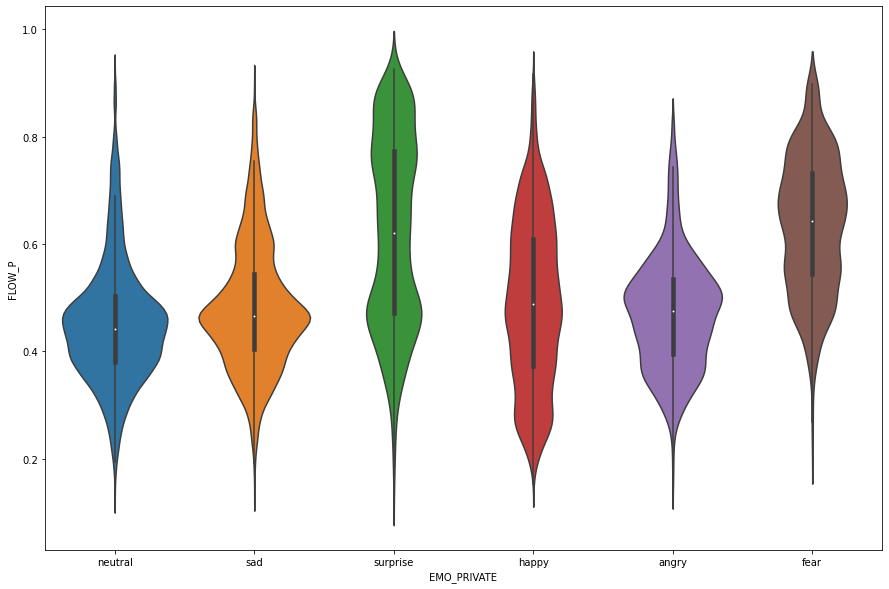

In [9]:
plt.figure(figsize=(15,10))
sns.violinplot(data=full_df[['FLOW_P','EMO_PRIVATE']], x='EMO_PRIVATE', y='FLOW_P')

In [ ]:
plt.figure(figsize=(15,10))
sns.pairplot(full_df[['FLOW_P','PRIVATE_angry', 'PRIVATE_fear', 'PRIVATE_happy',
                      'PRIVATE_neutral','PRIVATE_sad', 'PRIVATE_surprise']])

<Figure size 1080x720 with 0 Axes>

In [11]:
final_data[['FLOW_P','PRIVATE_angry', 'PRIVATE_fear', 'PRIVATE_happy',
                      'PRIVATE_neutral','PRIVATE_sad', 'PRIVATE_surprise']].corr(method='pearson')

,FLOW_P,PRIVATE_angry,PRIVATE_fear,PRIVATE_happy,PRIVATE_neutral,PRIVATE_sad,PRIVATE_surprise
FLOW_P,1.000000,0.078060,0.409426,0.163503,-0.368200,0.233847,0.464429
PRIVATE_angry,0.078060,1.000000,-0.022225,0.062755,-0.326260,0.076308,0.013108
PRIVATE_fear,0.409426,-0.022225,1.000000,0.011470,-0.235562,0.158952,0.682312
PRIVATE_happy,0.163503,0.062755,0.011470,1.000000,-0.573507,-0.168171,0.075073
PRIVATE_neutral,-0.368200,-0.326260,-0.235562,-0.573507,1.000000,-0.669943,-0.209147
PRIVATE_sad,0.233847,0.076308,0.158952,-0.168171,-0.669943,1.000000,0.039479
PRIVATE_surprise,0.464429,0.013108,0.682312,0.075073,-0.209147,0.039479,1.000000


In [12]:
print('SURPRISE and FLOW:',pearsonr(final_data['FLOW_P'], final_data['PRIVATE_surprise']))
print('FEAR and FLOW:',pearsonr(final_data['FLOW_P'], final_data['PRIVATE_fear']))
print('HAPPY and FLOW:',pearsonr(final_data['FLOW_P'], final_data['PRIVATE_happy']))
print('ANGRY and FLOW:',pearsonr(final_data['FLOW_P'], final_data['PRIVATE_angry']))
print('SAD and FLOW', pearsonr(final_data['FLOW_P'], final_data['PRIVATE_sad']))

SURPRISE and FLOW: (0.46442932322319813, 0.00031128925642998615)
FEAR and FLOW: (0.4094258184231801, 0.0017282312033270492)
HAPPY and FLOW: (0.16350313592089297, 0.22856178224355592)
ANGRY and FLOW: (0.07805993014894529, 0.567426542692628)
SAD and FLOW (0.2338474352742906, 0.08280718071011998)


### EMO Public

<AxesSubplot:xlabel='EMO_PUBLIC', ylabel='FLOW_P'>

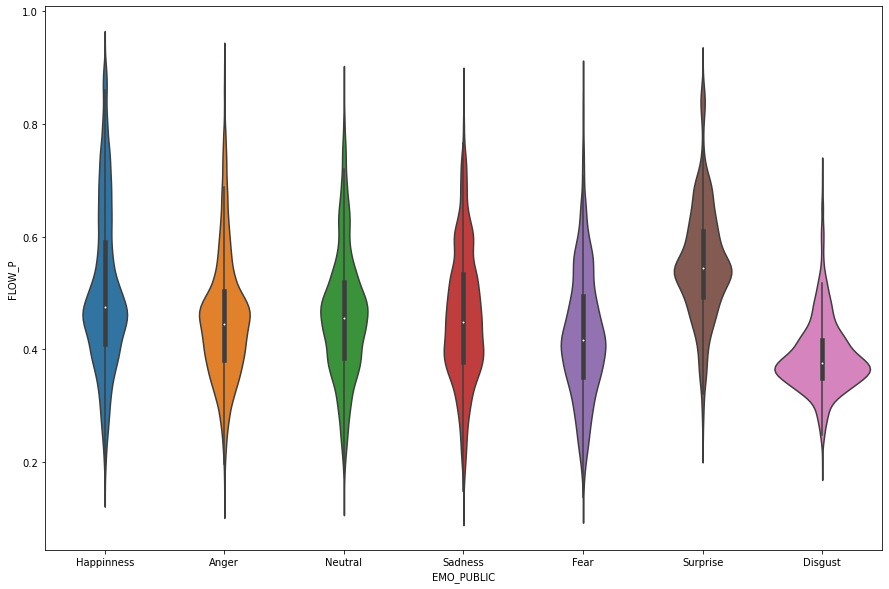

In [13]:
plt.figure(figsize=(15,10))
sns.violinplot(data=full_df[['FLOW_P','EMO_PUBLIC']], x='EMO_PUBLIC', y='FLOW_P')

<Figure size 1080x720 with 0 Axes>

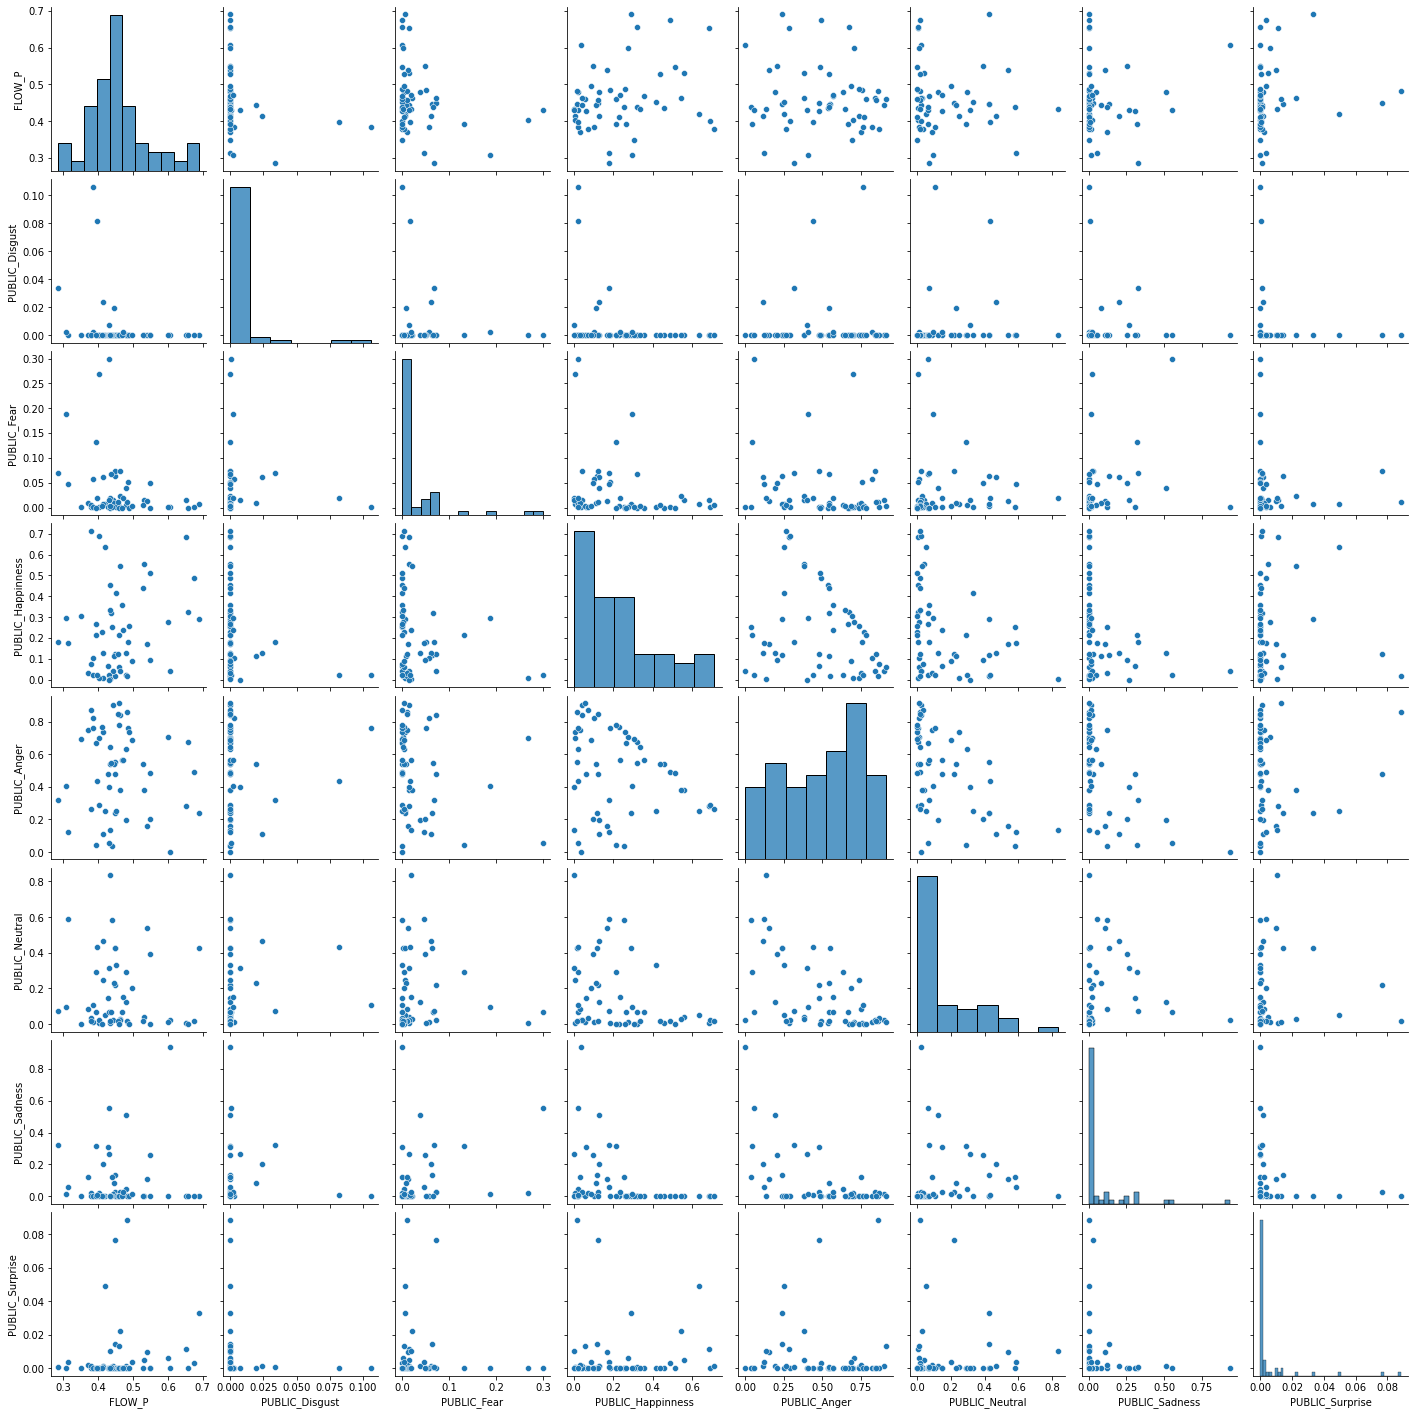

In [14]:
plt.figure(figsize=(15,10))
sns.pairplot(full_df[['FLOW_P','PRIVATE_ANGRY_P', 'PRIVATE_FEAR_P', 'PRIVATE_HAPPY_P',
                      'PRIVATE_NEUTRAL_P','PRIVATE_SAD_P', 'PRIVATE_SURPRISE_P']])

In [ ]:
plt.figure(figsize=(15,10))
sns.pairplot(final_data[['FLOW_P','PUBLIC_Disgust', 'PUBLIC_Fear', 'PUBLIC_Happinness',
                         'PUBLIC_Anger','PUBLIC_Neutral', 'PUBLIC_Sadness', 'PUBLIC_Surprise']])

In [15]:
final_data[['FLOW_P','PUBLIC_Disgust', 'PUBLIC_Fear', 'PUBLIC_Happinness',
                         'PUBLIC_Anger','PUBLIC_Neutral', 'PUBLIC_Sadness', 'PUBLIC_Surprise']].corr(method='spearman')


,FLOW_P,PUBLIC_Disgust,PUBLIC_Fear,PUBLIC_Happinness,PUBLIC_Anger,PUBLIC_Neutral,PUBLIC_Sadness,PUBLIC_Surprise
FLOW_P,1.000000,-0.318860,-0.217159,0.189064,-0.026726,-0.142825,-0.092765,0.191056
PUBLIC_Disgust,-0.318860,1.000000,0.275670,-0.299547,-0.142975,0.234025,0.385783,-0.228937
PUBLIC_Fear,-0.217159,0.275670,1.000000,-0.301109,-0.235017,0.323795,0.383344,0.276540
PUBLIC_Happinness,0.189064,-0.299547,-0.301109,1.000000,-0.209091,-0.370751,-0.455135,0.108549
PUBLIC_Anger,-0.026726,-0.142975,-0.235017,-0.209091,1.000000,-0.560843,-0.397573,-0.204392
PUBLIC_Neutral,-0.142825,0.234025,0.323795,-0.370751,-0.560843,1.000000,0.547085,0.201795
PUBLIC_Sadness,-0.092765,0.385783,0.383344,-0.455135,-0.397573,0.547085,1.000000,-0.106488
PUBLIC_Surprise,0.191056,-0.228937,0.276540,0.108549,-0.204392,0.201795,-0.106488,1.000000


In [16]:
full_df.columns

Index(['FLOW_P', 'VID', 'FRAME', 'FLOW_C', 'FLOW_P_C', 'EMO_PRIVATE',
       'PRIVATE_ANGRY_P', 'PRIVATE_FEAR_P', 'PRIVATE_HAPPY_P',
       'PRIVATE_NEUTRAL_P', 'PRIVATE_SAD_P', 'PRIVATE_SURPRISE_P',
       'PRIVATE_angry', 'PRIVATE_fear', 'PRIVATE_happy', 'PRIVATE_neutral',
       'PRIVATE_sad', 'PRIVATE_surprise', 'EMO_PUBLIC', 'PUBLIC_Anger',
       'PUBLIC_Disgust', 'PUBLIC_Fear', 'PUBLIC_Happinness', 'PUBLIC_Neutral',
       'PUBLIC_Sadness', 'PUBLIC_Surprise'],
      dtype='object')